[Dokumentacja Ray Tune](https://docs.ray.io/en/latest/tune/key-concepts.html)

# Wstęp

Notebook zaczniemy od załadowania prostego problemu do wyuczenia, tj. trening sieci konwolucyjnej na CIFAR10. Wytrenujemy sieć w podstawowy sposób, a następnie spróbujemy skorzystać z Ray Tune, by proces uczenia popchnąć w stronę lepszych wyników modelu.

W trakcie przygotowań zauważymy sporo hiperparametrów uczenia, które będziemy próbowali optymalizować z pomocą Ray Tune. Hiperparametry te dla widoczności będziemy zapisywać wielkimi literami z przedrostkiem `HP`.

# Prosty problem do wyuczenia

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ray import tune
from ray.tune.schedulers import ASHAScheduler
import ray
from ray import train
import ray.cloudpickle as pickle
import os, tempfile
from ray.train import Checkpoint
from ray.air import ScalingConfig


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


## Transformacje, DataLoadery, etykiety klas

Zacznijmy od przygotowania zbiorów danych uczących i testowych.

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

HP_BATCH_SIZE = 4

dataset_location = "./data"

trainset = torchvision.datasets.CIFAR10(
    root=dataset_location, train=True, download=True, transform=transform
)
trainloader = DataLoader(
    trainset, batch_size=HP_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)

testset = torchvision.datasets.CIFAR10(
    root=dataset_location, train=False, download=True, transform=transform
)
testloader = DataLoader(
    testset, batch_size=HP_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


Files already downloaded and verified
Files already downloaded and verified


## Trenowana sieć neuronowa

Przygotujmy sieć o nazwie `Net`, która jest prostą siecią konwolucyjną użytą w naszym zadaniu.

In [3]:
HP_NET_OUT_CHANNELS_1 = 6
HP_NET_KERNEL_SIZE = 5
HP_NET_OUT_CHANNELS_2 = 16
HP_NET_LINEAR_SIZE_1 = 120
HP_NET_LINEAR_SIZE_2 = 84


class Net(nn.Module):
    def __init__(
        self, out_channels_1, out_channels_2, kernel_size, linear_size_1, linear_size_2
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(3, out_channels_1, kernel_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(out_channels_1, out_channels_2, kernel_size)
        self.flatten = nn.Flatten(1)

        with torch.no_grad():
            fc1_size = self.flatten(
                self.pool(self.conv2(self.pool(self.conv1(torch.ones(1, 3, 32, 32)))))
            ).shape[1]

        self.fc1 = nn.Linear(fc1_size, linear_size_1)
        self.fc2 = nn.Linear(linear_size_1, linear_size_2)
        self.fc3 = nn.Linear(linear_size_2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


device = "cuda:0" if torch.cuda.is_available() else "cpu"

net = Net(
    HP_NET_OUT_CHANNELS_1,
    HP_NET_OUT_CHANNELS_2,
    HP_NET_KERNEL_SIZE,
    HP_NET_LINEAR_SIZE_1,
    HP_NET_LINEAR_SIZE_2,
).to(device)


## Funkcja błędu, optymalizator SGD

In [4]:
HP_SGD_LEARNING_RATE = 0.001
HP_SGD_MOMENTUM = 0.9

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


## Trening

In [5]:
for epoch in range(1):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Finished Training")


[1,  2000] loss: 2.209
[1,  4000] loss: 1.840
[1,  6000] loss: 1.672
[1,  8000] loss: 1.581
[1, 10000] loss: 1.540
[1, 12000] loss: 1.493
Finished Training


## Zapis wytrenowanego modelu do pliku

In [6]:
PATH = "./data/tune-example/cifar_net.pth"
torch.save(net.state_dict(), PATH)


## Ocena wyników

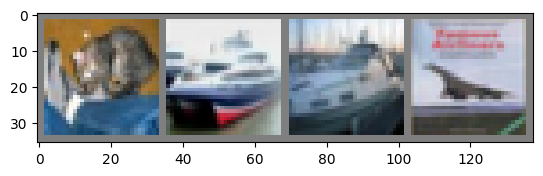

Ground truth:  cat   ship  ship  plane
Predicted:  cat   ship  car   ship 


In [7]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print("Ground truth: ", " ".join(f"{classes[labels[j]]:5s}" for j in range(4)))

best_net = Net(
    HP_NET_OUT_CHANNELS_1,
    HP_NET_OUT_CHANNELS_2,
    HP_NET_KERNEL_SIZE,
    HP_NET_LINEAR_SIZE_1,
    HP_NET_LINEAR_SIZE_2,
)
best_net.load_state_dict(torch.load(PATH))
outputs = best_net(images)

_, predicted = torch.max(outputs, 1)

print("Predicted: ", " ".join(f"{classes[predicted[j]]:5s}" for j in range(4)))


In [8]:
preds = []
ground_truth = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = best_net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        preds.append(predicted)
        ground_truth.append(labels)


preds = torch.hstack(preds)
ground_truth = torch.hstack(ground_truth)

print(
    f"Accuracy of the network on the 10000 test images: {accuracy_score(ground_truth, preds)} %"
)
print(
    f"F1 macro of the network on the 10000 test images: {f1_score(ground_truth, preds, average='macro')} %"
)


Accuracy of the network on the 10000 test images: 0.4891 %
F1 macro of the network on the 10000 test images: 0.4762332150044317 %


## Podsumowanie pierwszej części

Model jest nieco lepszy (F1 score ~$50\%$) niż losowy wybór, jednak czy da się poprawić jego wynik? Spróbujmy nasz trening ulepszyć z pomocą Ray Tune.

# Ray Tune

Ray Tune jest biblioteką służącą do rozproszonego uruchamiania eksperymentów ML i optymalizacji ich hiperparametrów. Wspiera różne biblioteki uczenia maszynowego (m.in. TensorFlow, PyTorch) oraz integruje się z innymi narzędziami optymalizacji hiperparametrów (np. Optuna, BayesOpt).

[Dokumentacja](https://docs.ray.io/en/latest/tune/key-concepts.html#key-concepts-of-ray-tune)

## Podstawowe pojęcia

- `search space` - przestrzeń poszukiwań wartości hiperparametrów, tj. jakie hiperparametry i jakie wartości dla nich
- `trainable` - optymalizowana funkcja celu. 
- `search algorithm` - metoda poszukiwania wartości hiperparametrów w przestrzeni
- `scheduler` - opcjonalny algorytm zatrzymujący nieobiecujące przeszukiwania
- `Tuner` - instancja eksperymentu, która gromadzi search space, trainable, search algorithm i scheduler 
- `trial` - pojedyncze uruchomienie eksperymentu w wybranej konfiguracji.

## Search space

Skonstruujmy przestrzeń poszukiwań dla naszego problemu. Ray dostarcza dużo różnych metod tworzenia przestrzeni dla każdego hiperparametru osobno, wśród których warto wyróżnić `loguniform`, która pozwala na łatwe przeszukiwanie wartości o różnych rzędach wielkości.

[Link do innych przestrzeni](https://docs.ray.io/en/latest/tune/api/search_space.html#tune-search-space)

In [41]:
config = {
    "HP_NET_OUT_CHANNELS_1": tune.lograndint(1, 100),
    "HP_NET_OUT_CHANNELS_2": tune.lograndint(1, 100),
    "HP_NET_KERNEL_SIZE": tune.randint(2, 6),
    "HP_NET_LINEAR_SIZE_1": tune.lograndint(1, 100),
    "HP_NET_LINEAR_SIZE_2": tune.lograndint(1, 100),
    "HP_BATCH_SIZE": tune.choice([2, 4, 8, 16, 32, 64, 128, 256, 512]),
    "HP_SGD_LEARNING_RATE": tune.loguniform(1e-5, 1e-1),
    "HP_SGD_MOMENTUM": tune.loguniform(1e-5, 1e-1),
}


## Trainable

Trainable to nic innego jak funkcja uczenia, która dodatkowo posiada możliwość przekazania do procesu Ray statystyk uczenia w trakcie swojego działania. Dzięki temu Ray może kontrolować, które procesy dają szansę na wysoki wynik, a które nie.

Trainable jest funkcją, która otrzymuje konfigurację danego eksperymentu jako `config`. Zawiera on m.in. hiperparametry w eksperymencie. Jest to zwykły `dict`.

Nasz trainable to będzie funkcja przygotowująca dataloadery + model + uczenie w jednym. Każdy z tych etapów potrzebuje jakichś hiperparametrów, stąd takie połączenie.

W kodzie można też zauważyć miejsca na checkpointy. Ray sam dba o to, by zapisywać/ładować trialsy z checkpointów.

[Link do API trainable](https://docs.ray.io/en/latest/tune/api/trainable.html#function-trainable-api)

In [42]:
dataset_location = "/home/stachu/MGR/projekt/data"
accuracy_metric_key = "training_accuracy"
training_epoch_key = "training_iteration"


def trainable(config):
    ## SETUP DATASETS

    HP_BATCH_SIZE = config["HP_BATCH_SIZE"]

    trainset = torchvision.datasets.CIFAR10(
        root=dataset_location, train=True, download=False, transform=transform
    )
    trainloader = DataLoader(
        trainset, batch_size=HP_BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
    )

    testset = torchvision.datasets.CIFAR10(
        root=dataset_location, train=False, download=False, transform=transform
    )
    testloader = DataLoader(
        testset, batch_size=HP_BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True
    )

    ## SETUP NET

    HP_NET_OUT_CHANNELS_1 = config["HP_NET_OUT_CHANNELS_1"]
    HP_NET_OUT_CHANNELS_2 = config["HP_NET_OUT_CHANNELS_2"]
    HP_NET_KERNEL_SIZE = config["HP_NET_KERNEL_SIZE"]
    HP_NET_LINEAR_SIZE_1 = config["HP_NET_LINEAR_SIZE_1"]
    HP_NET_LINEAR_SIZE_2 = config["HP_NET_LINEAR_SIZE_2"]

    net = Net(
        HP_NET_OUT_CHANNELS_1,
        HP_NET_OUT_CHANNELS_2,
        HP_NET_KERNEL_SIZE,
        HP_NET_LINEAR_SIZE_1,
        HP_NET_LINEAR_SIZE_2,
    )

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)

    HP_SGD_LEARNING_RATE = config["HP_SGD_LEARNING_RATE"]
    HP_SGD_MOMENTUM = config["HP_SGD_MOMENTUM"]

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.SGD(
        net.parameters(), lr=HP_SGD_LEARNING_RATE, momentum=HP_SGD_MOMENTUM
    )

    if train.get_checkpoint():
        with train.get_checkpoint().as_directory() as checkpoint_dir:
            with open(os.path.join(checkpoint_dir, "data.pkl"), "rb") as fp:
                checkpoint_state = pickle.load(fp)
                start_epoch = checkpoint_state["epoch"]
                net.load_state_dict(checkpoint_state["net_state_dict"])
                optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    num_epochs = 100  # for now it is constant to make it shorter

    for i in range(start_epoch, num_epochs):
        ## ONE TRAINING EPOCH
        for data in trainloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

        ## EVALUATION ON TEST SET AFTER ONE TRAINING EPOCH
        preds = []
        ground_truth = []
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = net(images)
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                preds.append(predicted)
                ground_truth.append(labels)

        preds = torch.hstack(preds)
        ground_truth = torch.hstack(ground_truth)
        accuracy = accuracy_score(ground_truth, preds)

        with tempfile.TemporaryDirectory() as checkpoint_dir:
            with open(os.path.join(checkpoint_dir, "data.pkl"), "wb") as fp:
                pickle.dump({"epoch": i}, fp)
                pickle.dump({"net_state_dict": net.state_dict()}, fp)
                pickle.dump({"optimizer_state_dict": optimizer.state_dict()}, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report(
                {training_epoch_key: i, accuracy_metric_key: accuracy},
                checkpoint=checkpoint,
            )


Zwróćmy uwagę na ostatnią linijkę z `train.report(...)`. Ona ma za zadanie po każdej epoce przekazać do Ray informację o wyniku, by można było ocenić, czy eksperyment idzie w dobrą stronę.

## Search algorithm

Domyślnie jako formę przeszukiwania Ray uruchamia zestaw $n$ losowych konfiguracji hiperparametrów i przyjmuje najlepszy wynik, a więc klasyczny random search. Istnieją jednak bardziej usystematyzowane metody, które Ray dostarcza, np. [NevergradSearch](https://docs.ray.io/en/latest/tune/api/suggestion.html#nevergrad) czy [HyperOptSearch](https://docs.ray.io/en/latest/tune/api/suggestion.html#tune-hyperopt). Bazują na istniejących bibliotekach SOTA do optymalizacji, a Ray opakowuje je w jeden interfejs.

W Ray, `search algorithm` nie wpływa na proces eksperymentu w jego trakcie, w szczególności nie przerywa go, gdy źle rokuje. Tym zajmuje się `scheduler`, o którym powiemy sobie za chwilę. `Search algorithm` tylko generuje konfiguracje hiperparametrów do sprawdzenia i wybiera najlepszy wynik.

[Więcej algorytmów](https://docs.ray.io/en/latest/tune/api/suggestion.html#tune-search-algorithms-tune-search)


In [43]:
from ray.tune.search.hyperopt import HyperOptSearch

search_algorithm = HyperOptSearch(metric=accuracy_metric_key, mode="max")


## Scheduler

Super że mamy przeszukiwanie z użyciem optymalizacji bayesowskiej. Ale co nam z tego, skoro proces uczenia tak naprawdę będzie odpalony na każdej konfiguracji, przebiegnie do końca i wybierzemy sobie najwyższy wynik... Czym to się różni od grid/random search? :(

Tu z pomocą przychodzi nam `scheduler`, który może wcześniej wyłączyć nieobiecujące eksperymenty, a pozostałe kontynuować.

Ray oferuje kilka algorytmów SOTA `scheduler`, np. [ASHA (Async Successive Halving Algorithm)](https://docs.ray.io/en/latest/tune/api/schedulers.html#tune-scheduler-hyperband) czy [HyperBand](https://docs.ray.io/en/latest/tune/api/schedulers.html#tune-original-hyperband)

My skorzystamy dziś z ASHA, by móc łatwo zwolnić zasoby dla eksperymentów, w których model nie uczy się efektywnie.

[Więcej przykładów schedulerów](https://docs.ray.io/en/latest/tune/api/schedulers.html#tune-trial-schedulers-tune-schedulers)

In [44]:
asha_scheduler = ASHAScheduler(
    time_attr=training_epoch_key,
    metric=accuracy_metric_key,
    mode="max",
    max_t=100,
    grace_period=10,
    reduction_factor=3,
    brackets=1,
)


## Tuner

Mając to wszystko razem, możemy utworzyć instancję `Tuner`, w której zawrzemy wszystkie przygotowane składowe eksperymentu. Następnie uruchomimy funkcję `fit()` i będziemy mogli sprawdzać wyniki eksperymentów.

In [45]:
%%html
<style>
.tuneStatus {
    background-color: white !important;
}
.trialStatus {
    overflow-x: scroll;
}
</style>

In [46]:
ray.shutdown()
ray.init()

tuner = tune.Tuner(
    trainable=tune.with_resources(
        trainable,
        resources=ScalingConfig(use_gpu=True),
    ),
    # replace the line above if you don't have GPU
    # trainable=trainable,
    tune_config=tune.TuneConfig(
        scheduler=asha_scheduler,
        search_alg=search_algorithm,
        num_samples=10,
        # you can use more concurrent trials if your PC can handle them
        max_concurrent_trials=4,
    ),
    param_space=config,
)

results = tuner.fit()


(trainable pid=20346) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/stachu/ray_results/trainable_2023-10-04_19-01-40/trainable_cdce6848_4_HP_BATCH_SIZE=512,HP_NET_KERNEL_SIZE=3,HP_NET_LINEAR_SIZE_1=3,HP_NET_LINEAR_SIZE_2=25,HP_NET_OUT_CHANNELS_1=1_2023-10-04_19-01-46/checkpoint_000000)
(trainable pid=20254) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/stachu/ray_results/trainable_2023-10-04_19-01-40/trainable_c7e1ec9b_3_HP_BATCH_SIZE=8,HP_NET_KERNEL_SIZE=5,HP_NET_LINEAR_SIZE_1=7,HP_NET_LINEAR_SIZE_2=2,HP_NET_OUT_CHANNELS_1=1,HP_2023-10-04_19-01-44/checkpoint_000000)
(trainable pid=20346) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/stachu/ray_results/trainable_2023-10-04_19-01-40/trainable_cdce6848_4_HP_BATCH_SIZE=512,HP_NET_KERNEL_SIZE=3,HP_NET_LINEAR_SIZE_1=3,HP_NET_LINEAR_SIZE_2=25,HP_NET_OUT_CHANNELS_1=1_2023-10-04_19-01-46/checkpoint_000001)
(trainable pid=20346) Checkpoint successfully cre

(trainable pid=20346) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/stachu/ray_results/trainable_2023-10-04_19-01-40/trainable_93099fad_9_HP_BATCH_SIZE=2,HP_NET_KERNEL_SIZE=5,HP_NET_LINEAR_SIZE_1=28,HP_NET_LINEAR_SIZE_2=2,HP_NET_OUT_CHANNELS_1=16,_2023-10-04_19-38-00/checkpoint_000090)


Ponieważ co odpalenie Ray Tune to inny zestaw wartości hiperparametrów, inne seedy i inne wyniki, dlatego też skopiowałem logi z tego odpalenia treningu (które u mnie trwało ok. 2h, ponieważ odnoszę wrażenie że nie wszystkie próby korzystały z GPU) do folderu `./data/sample-ray-logs`.

Logi z każdego treningu Raya są kompatybilne z Tensorboardem, zatem by obejrzeć rezultaty wszystkich prób, możemy uruchomić `tensorboard --logdir ./data/sample-ray-logs` i obejrzeć wyniki.

Możemy zauważyć korzystny zestaw hiperparametrów (skok z $50\%$ accuracy do $\sim 68\%$):

| HP_BATCH_SIZE | HP_NET_KERNEL_SIZE | HP_NET_LINEAR_SIZE_1 | HP_NET_LINEAR_SIZE_2 | HP_NET_OUT_CHANNELS_1 | HP_NET_OUT_CHANNELS_2 | HP_SGD_LEARNING_RATE | HP_SGD_MOMENTUM       | ray/tune/training_accuracy |
|---------------|--------------------|----------------------|----------------------|-----------------------|-----------------------|----------------------|-----------------------|----------------------------|
| 128.0         | 3.0                | 9.0                  | 28.0                 | 54.0                  | 61.0                  | 0.02927921466663529  | 8.030329827594446e-05 | 0.6794000267982483         |

Spróbujmy wyuczyć model na nim jeszcze raz, zobaczmy co się stanie...

In [49]:
net = Net(
    54,
    61,
    3,
    9,
    18,
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(
    net.parameters(), lr=0.02927921466663529, momentum=8.030329827594446e-05
)

trainloader = DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True
)

for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}")
            running_loss = 0.0

print("Finished Training")


[1,   100] loss: 2.309
[1,   200] loss: 2.296
[1,   300] loss: 2.278
[2,   100] loss: 2.197
[2,   200] loss: 2.128
[2,   300] loss: 2.037
[3,   100] loss: 1.881
[3,   200] loss: 1.827
[3,   300] loss: 1.767
[4,   100] loss: 1.660
[4,   200] loss: 1.623
[4,   300] loss: 1.581
[5,   100] loss: 1.526
[5,   200] loss: 1.488
[5,   300] loss: 1.464
[6,   100] loss: 1.429
[6,   200] loss: 1.402
[6,   300] loss: 1.384
[7,   100] loss: 1.348
[7,   200] loss: 1.352
[7,   300] loss: 1.316
[8,   100] loss: 1.285
[8,   200] loss: 1.274
[8,   300] loss: 1.260
[9,   100] loss: 1.223
[9,   200] loss: 1.232
[9,   300] loss: 1.205
[10,   100] loss: 1.173
[10,   200] loss: 1.164
[10,   300] loss: 1.159
[11,   100] loss: 1.126
[11,   200] loss: 1.104
[11,   300] loss: 1.117
[12,   100] loss: 1.083
[12,   200] loss: 1.060
[12,   300] loss: 1.061
[13,   100] loss: 1.035
[13,   200] loss: 1.033
[13,   300] loss: 1.036
[14,   100] loss: 1.001
[14,   200] loss: 0.999
[14,   300] loss: 0.987
[15,   100] loss: 0

In [52]:
preds = []
ground_truth = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.cuda())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        preds.append(predicted)
        ground_truth.append(labels)


preds = torch.hstack(preds)
ground_truth = torch.hstack(ground_truth)

print(
    f"Accuracy of the network on the 10000 test images: {accuracy_score(ground_truth.cpu(), preds.cpu())} %"
)
print(
    f"F1 macro of the network on the 10000 test images: {f1_score(ground_truth.cpu(), preds.cpu(), average='macro')} %"
)


Accuracy of the network on the 10000 test images: 0.6558 %
F1 macro of the network on the 10000 test images: 0.6569000336406474 %


Wynik jest bardzo podobny do tego, który uzyskaliśmy poprzednim razem (różnica $2$ p.p.). To znaczy, że:

- udało się nam poprawić za pomocą Raya wynik modelu
- proponowane przez Raya hiperparametry dają podobne wyniki również po całym procesie przeszukiwania, są zatem wiarygodne

Cel zadania postawiony w tym notebooku został osiągnięty.